# LSTM model
This notebook deals with training & testing an LSTM model for bitcoin price prediction. We'll use PyTorch and particularly PyTorch Lightning modules to build the network.

In [1]:
# import necessary libraries and read data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.metrics.functional import accuracy
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
# df = pd.read_csv('data/raw.csv').drop(columns='market_caps')

### Preprocessing & Setup
The LSTM takes data in the format `(batch_len, seq_len, n_features)`, so we'll do some data preprocessing to get it into that format (soon). In this case, the batch length is the number of labeled samples, and the sequence length is the number of timesteps per sample.

In [2]:
# splitting data at random into train/test sets, since we've fixed all the time-dependencies
class BTCData(pl.LightningDataModule):
    def __init__(self, filename, nrows=None):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.filename = filename
        self.batch_size = 64
        self.nrows = nrows
        
    # load data from file
    def load_data(self):
        if self.nrows is not None:
            return np.load(self.filename)[:self.nrows]
        return np.load(self.filename)
    
    # create pytorch dataset from data
    def make_dataset(self, X, y):
        X = torch.Tensor(X)
        y = torch.Tensor(y).type(torch.LongTensor)
        
        return TensorDataset(X, y)
        
    def setup(self, stage):
        # load dataset, split into X and y, relabel y to {0, 1}
        dataset = self.load_data()
        X = dataset[:, :-1]
        y = dataset[:, -1]
        y[y == -1] = 0
                
        # transform data
        X = self.scaler.fit_transform(X)
                
        # group data into sequences
        self.seq_len = 60
        full_len = len(X) - self.seq_len
        self.n_features = 6
        X_sequenced = np.zeros((full_len, self.seq_len, self.n_features))
        for i in range(full_len):
            X_sequenced[i] = X[i:i + self.seq_len]
        y = y[self.seq_len:]
            
        # split into train, validate, and test datasets
        test_size = 0.2
        val_size = 0.125
        X_train, X_test, y_train, y_test = train_test_split(X_sequenced, y, test_size=test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)
        
        # create the datasets
        self.train = self.make_dataset(X_train, y_train)
        self.val = self.make_dataset(X_val, y_val)
        self.test = self.make_dataset(X_test, y_test)
        
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

In [3]:
# lightning module structure
class LSTM_Classifier(LightningModule):
    def __init__(self, n_features, hidden, seq_len, classes):
        super().__init__()
        
        self.hidden = hidden
        self.seq_len = seq_len
        self.n_classes = classes
        
        # lstm layer and linear hidden-state to classes layer
        # lstm inputs a batch of samples of shape (seq_len, n_features),
        #   outputs 1 hidden state of shape (seq_len, hidden_size)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=self.hidden, batch_first=True)
        # change the output to 2
        self.h2c = nn.Linear(hidden * seq_len, self.n_classes)
    
    def accuracy(self, y_hat, y):
        return (torch.max(y_hat, 1).indices == y).to(torch.float32).mean()
    
    # forward step - classification
    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        class_preds = self.h2c(lstm_out.view((-1, self.seq_len * self.hidden)))
        return F.softmax(class_preds, -1)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        
        train_loss = F.cross_entropy(y_hat.view((-1, self.n_classes)), y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', train_loss, logger=True)
        self.log('train_accuracy', acc, prog_bar=True, logger=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        
        val_loss = F.cross_entropy(y_hat.view((-1, self.n_classes)), y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', val_loss, logger=True, on_epoch=True)
        self.log('val_accuracy', acc, prog_bar=True, logger=True, on_epoch=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        
        test_loss = F.cross_entropy(y_hat.view((-1, self.n_classes)), y)
        acc = self.accuracy(y_hat, y)
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        self.log('test_accuracy', acc, prog_bar=True, logger=True)
        return test_loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

Notes/TODO:
- Softmax is good for multiclass, and works well with cross-entropy loss. However, the torch cross-entropy loss fn. expects scores $0 \leq s \leq 1$ for each possible class. I've added a linear layer that maps LSTM output to a score for each class, and applied the softmax activation fn. to it. I also changed the label for "buy" from -1 to 2, to be within the expected $0 \leq l \leq C - 1$ range.
- Apparently I need to add an explicit dimension for softmax - this might just be a -1 at the end of the call
- I should also implement validation for the LSTM, so it's not just train & test & hope for the best

### Training
Now we're ready to actually train the model. I'll use the PL Trainer module to handle training.

In [12]:
pl.seed_everything(4622)

# feature params
n_features = 6
hidden = 1
seq_len = 60
classes = 2

# instantiate dataset, dataloader, model, and trainer
logger = CSVLogger("logs", name="lstm")
train_dl = BTCData('data/labeled_data.npy')
lstm_model = LSTM_Classifier(n_features, hidden, seq_len, classes)
trainer = pl.Trainer(deterministic=True, logger=logger, gpus=int(torch.cuda.is_available()),
                    max_epochs=100, auto_scale_batch_size=True)
trainer.tune(lstm_model, train_dl)

Global seed set to 4622
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Batch size 2 succeeded, trying batch size 4
Batch size 4 succeeded, trying batch size 8
Batch size 8 succeeded, trying batch size 16
Batch size 16 succeeded, trying batch size 32
Batch size 32 succeeded, trying batch size 64
Batch size 64 succeeded, trying batch size 128
Batch size 128 succeeded, trying batch size 256
Batch size 256 succeeded, trying batch size 512
Batch size 512 succeeded, trying batch size 1024
Batch size 1024 succeeded, trying batch size 2048
Batch size 2048 succeeded, trying batch size 4096
Batch size 4096 succeeded, trying batch size 8192
Batch size 8192 succeeded, trying batch size 16384
Batch size 16384 succeeded, trying batch size 32768
Batch size 32768 succeeded, trying batch size 65536
Batch size 65536 succeeded, trying batch size 131072
Batch size 131072 succeeded, trying batch size 262144
Batch size 131625 succeeded, trying batch size 263250
Finished batch siz

In [13]:
trainer.fit(lstm_model, train_ds)


  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 36    
1 | h2c  | Linear | 122   
--------------------------------
158       Trainable params
0         Non-trainable params
158       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  87%|█████▏| 2057/2351 [00:40<00:05, 50.27it/s, loss=0.694, v_num=1, val_accuracy=0.461, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 1:  87%|█████▏| 2057/2351 [00:39<00:05, 51.67it/s, loss=0.693, v_num=1, val_accuracy=0.495, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 2:  87%|█████▏| 2057/2351 [00:42<00:06, 48.79it/s, loss=0.693, v_num=1, val_accuracy=0.495, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 3:  87%|█████▏| 2057/2351 [00:43<00:06, 47.07it/s, loss=0.693, v_num=1, val_accuracy=0.495, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 4:  87%|█████▏| 2057/2351 [00:41<00:06, 48.98it/s, loss=0.693, v_num=1, val_accuracy=0.495, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 4:  97%|█████▊| 2291/2351 [00:43<00:01, 52.86it/s, loss=0.693, v_num=1, val_accuracy=0.495, train_accuracy=0.469]


Epoch 5:  87%|█████▏| 2057/2351 [00:42<00:06, 48.78it/s, loss=0.693, v_num=1, val_accuracy=0.495, train_accuracy=0.484]
Validating: 0it [00:00, ?it/s]
Epoch 6:  87%|█████▏| 2057/2351 [00:47<00:06, 43.34it/s, loss=0.693, v_num=1, val_accuracy=0.500, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 7:  87%|█████▏| 2057/2351 [00:40<00:05, 51.42it/s, loss=0.693, v_num=1, val_accuracy=0.503, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 8:  87%|█████▏| 2057/2351 [00:41<00:05, 49.44it/s, loss=0.693, v_num=1, val_accuracy=0.503, train_accuracy=0.453]
Validating: 0it [00:00, ?it/s]
Epoch 9:  87%|█████▏| 2057/2351 [00:40<00:05, 50.97it/s, loss=0.693, v_num=1, val_accuracy=0.503, train_accuracy=0.453]
Validating: 0it [00:00, ?it/s]
Validating:   7%|████▉                                                                | 21/294 [00:00<00:10, 25.73it/s]


Epoch 10:  87%|████▎| 2057/2351 [00:40<00:05, 50.68it/s, loss=0.693, v_num=1, val_accuracy=0.503, train_accuracy=0.453]
Validating: 0it [00:00, ?it/s]
Epoch 11:  87%|████▎| 2057/2351 [00:41<00:05, 49.56it/s, loss=0.693, v_num=1, val_accuracy=0.503, train_accuracy=0.453]
Validating: 0it [00:00, ?it/s]
Epoch 12:  87%|████▎| 2057/2351 [00:43<00:06, 47.15it/s, loss=0.693, v_num=1, val_accuracy=0.504, train_accuracy=0.453]
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█████| 2351/2351 [00:45<00:00, 51.78it/s, loss=0.693, v_num=1, val_accuracy=0.502, train_accuracy=0.610]


Epoch 13:  87%|████▎| 2057/2351 [00:41<00:05, 49.78it/s, loss=0.693, v_num=1, val_accuracy=0.502, train_accuracy=0.422]
Validating: 0it [00:00, ?it/s]
Epoch 14:  87%|████▎| 2057/2351 [00:36<00:05, 56.55it/s, loss=0.693, v_num=1, val_accuracy=0.502, train_accuracy=0.438]
Validating: 0it [00:00, ?it/s]
Epoch 15:  87%|████▎| 2057/2351 [00:44<00:06, 45.92it/s, loss=0.693, v_num=1, val_accuracy=0.500, train_accuracy=0.453]
Validating: 0it [00:00, ?it/s]
Epoch 16:  87%|████▎| 2057/2351 [00:43<00:06, 46.88it/s, loss=0.694, v_num=1, val_accuracy=0.500, train_accuracy=0.438]
Validating: 0it [00:00, ?it/s]
Epoch 17:  87%|████▎| 2057/2351 [00:42<00:06, 48.23it/s, loss=0.694, v_num=1, val_accuracy=0.500, train_accuracy=0.453]
Validating: 0it [00:00, ?it/s]
Epoch 17:  96%|████▊| 2263/2351 [00:43<00:01, 51.54it/s, loss=0.694, v_num=1, val_accuracy=0.500, train_accuracy=0.453]


Epoch 18:  87%|████▎| 2057/2351 [00:44<00:06, 46.68it/s, loss=0.694, v_num=1, val_accuracy=0.503, train_accuracy=0.453]
Validating: 0it [00:00, ?it/s]
Epoch 19:  87%|████▎| 2057/2351 [00:44<00:06, 45.87it/s, loss=0.694, v_num=1, val_accuracy=0.504, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 20:  87%|████▎| 2057/2351 [00:45<00:06, 45.64it/s, loss=0.694, v_num=1, val_accuracy=0.505, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 21:  87%|████▎| 2057/2351 [00:45<00:06, 45.03it/s, loss=0.694, v_num=1, val_accuracy=0.506, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 22:  87%|████▎| 2057/2351 [00:40<00:05, 50.64it/s, loss=0.694, v_num=1, val_accuracy=0.507, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Validating:   7%|█████                                                               | 22/294 [00:00<00:01, 214.17it/s]


Epoch 23:  87%|████▎| 2057/2351 [00:46<00:06, 44.70it/s, loss=0.693, v_num=1, val_accuracy=0.508, train_accuracy=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 24:  87%|████▎| 2057/2351 [00:40<00:05, 50.92it/s, loss=0.693, v_num=1, val_accuracy=0.509, train_accuracy=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 25:  87%|████▎| 2057/2351 [00:48<00:06, 42.79it/s, loss=0.693, v_num=1, val_accuracy=0.512, train_accuracy=0.500]
Validating: 0it [00:00, ?it/s]
Epoch 26:  87%|████▎| 2057/2351 [00:43<00:06, 46.97it/s, loss=0.693, v_num=1, val_accuracy=0.515, train_accuracy=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 26:  99%|████▉| 2325/2351 [00:45<00:00, 51.47it/s, loss=0.693, v_num=1, val_accuracy=0.515, train_accuracy=0.516]


Epoch 27:  87%|████▎| 2057/2351 [00:42<00:06, 48.00it/s, loss=0.693, v_num=1, val_accuracy=0.516, train_accuracy=0.500]
Validating: 0it [00:00, ?it/s]
Epoch 28:  87%|████▎| 2057/2351 [00:46<00:06, 44.24it/s, loss=0.693, v_num=1, val_accuracy=0.519, train_accuracy=0.500]
Validating: 0it [00:00, ?it/s]
Epoch 29:  87%|████▎| 2057/2351 [00:42<00:06, 48.47it/s, loss=0.693, v_num=1, val_accuracy=0.519, train_accuracy=0.500]
Validating: 0it [00:00, ?it/s]
Epoch 30:  87%|████▎| 2057/2351 [00:44<00:06, 45.95it/s, loss=0.693, v_num=1, val_accuracy=0.520, train_accuracy=0.500]
Validating: 0it [00:00, ?it/s]
Epoch 31:  87%|████▎| 2057/2351 [00:44<00:06, 45.88it/s, loss=0.693, v_num=1, val_accuracy=0.520, train_accuracy=0.531]
Validating: 0it [00:00, ?it/s]
Epoch 31:  91%|████▌| 2139/2351 [00:45<00:04, 47.03it/s, loss=0.693, v_num=1, val_accuracy=0.520, train_accuracy=0.531]


Epoch 32:  87%|████▎| 2057/2351 [00:45<00:06, 45.60it/s, loss=0.693, v_num=1, val_accuracy=0.520, train_accuracy=0.547]
Validating: 0it [00:00, ?it/s]
Epoch 33:  87%|████▎| 2057/2351 [00:46<00:06, 44.70it/s, loss=0.693, v_num=1, val_accuracy=0.522, train_accuracy=0.547]
Validating: 0it [00:00, ?it/s]
Epoch 34:  87%|████▎| 2057/2351 [00:46<00:06, 44.66it/s, loss=0.693, v_num=1, val_accuracy=0.522, train_accuracy=0.562]
Validating: 0it [00:00, ?it/s]
Epoch 35:  87%|████▎| 2057/2351 [00:44<00:06, 46.63it/s, loss=0.693, v_num=1, val_accuracy=0.522, train_accuracy=0.547]
Validating: 0it [00:00, ?it/s]
Validating:  64%|███████████████████████████████████████████                        | 189/294 [00:01<00:00, 140.70it/s]


Epoch 36:  87%|████▎| 2057/2351 [00:46<00:06, 44.40it/s, loss=0.693, v_num=1, val_accuracy=0.523, train_accuracy=0.547]
Validating: 0it [00:00, ?it/s]
Epoch 37:  87%|████▎| 2057/2351 [00:43<00:06, 47.80it/s, loss=0.693, v_num=1, val_accuracy=0.524, train_accuracy=0.562]
Validating: 0it [00:00, ?it/s]
Epoch 38:  87%|████▎| 2057/2351 [00:43<00:06, 47.48it/s, loss=0.693, v_num=1, val_accuracy=0.524, train_accuracy=0.562]
Validating: 0it [00:00, ?it/s]
Epoch 39:  87%|████▎| 2057/2351 [00:45<00:06, 45.62it/s, loss=0.693, v_num=1, val_accuracy=0.525, train_accuracy=0.578]
Validating: 0it [00:00, ?it/s]
Epoch 40:  87%|████▎| 2057/2351 [00:46<00:06, 43.96it/s, loss=0.693, v_num=1, val_accuracy=0.524, train_accuracy=0.594]
Validating: 0it [00:00, ?it/s]


Epoch 41:  87%|████▎| 2057/2351 [00:44<00:06, 46.65it/s, loss=0.693, v_num=1, val_accuracy=0.525, train_accuracy=0.594]
Validating: 0it [00:00, ?it/s]
Epoch 42:  87%|████▎| 2057/2351 [00:48<00:06, 42.64it/s, loss=0.693, v_num=1, val_accuracy=0.525, train_accuracy=0.594]
Validating: 0it [00:00, ?it/s]
Epoch 43:  87%|████▎| 2057/2351 [00:48<00:06, 42.80it/s, loss=0.693, v_num=1, val_accuracy=0.525, train_accuracy=0.594]
Validating: 0it [00:00, ?it/s]
Epoch 44:  87%|████▎| 2057/2351 [00:50<00:07, 40.85it/s, loss=0.693, v_num=1, val_accuracy=0.526, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 44:  94%|████▋| 2201/2351 [00:51<00:03, 42.96it/s, loss=0.693, v_num=1, val_accuracy=0.526, train_accuracy=0.609]


Epoch 45:  87%|████▎| 2057/2351 [00:45<00:06, 44.92it/s, loss=0.693, v_num=1, val_accuracy=0.526, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 46:  87%|████▎| 2057/2351 [00:45<00:06, 45.43it/s, loss=0.693, v_num=1, val_accuracy=0.526, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 47:  87%|████▎| 2057/2351 [00:42<00:06, 48.57it/s, loss=0.692, v_num=1, val_accuracy=0.526, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 48:  87%|████▎| 2057/2351 [00:38<00:05, 54.07it/s, loss=0.692, v_num=1, val_accuracy=0.526, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 49:  87%|████▎| 2057/2351 [00:37<00:05, 54.34it/s, loss=0.692, v_num=1, val_accuracy=0.526, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 49:  92%|████▌| 2170/2351 [00:38<00:03, 56.27it/s, loss=0.692, v_num=1, val_accuracy=0.526, train_accuracy=0.625]


Epoch 50:  87%|████▎| 2057/2351 [00:39<00:05, 52.41it/s, loss=0.692, v_num=1, val_accuracy=0.526, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 51:  87%|████▎| 2057/2351 [00:38<00:05, 53.72it/s, loss=0.692, v_num=1, val_accuracy=0.526, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 52:  87%|████▎| 2057/2351 [00:45<00:06, 44.80it/s, loss=0.692, v_num=1, val_accuracy=0.526, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 53:  87%|████▎| 2057/2351 [00:46<00:06, 44.46it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 54:  87%|████▎| 2057/2351 [00:46<00:06, 43.94it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 54:  88%|████▍| 2077/2351 [00:47<00:06, 44.09it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.625]


Epoch 55:  87%|████▎| 2057/2351 [00:45<00:06, 45.50it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 56:  87%|████▎| 2057/2351 [00:45<00:06, 45.30it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 57:  87%|████▎| 2057/2351 [00:47<00:06, 43.22it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 58:  87%|████▎| 2057/2351 [00:46<00:06, 43.97it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 58:  95%|████▋| 2232/2351 [00:47<00:02, 46.72it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.641]


Epoch 59:  87%|████▎| 2057/2351 [00:42<00:06, 48.63it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 60:  87%|████▎| 2057/2351 [00:42<00:06, 48.06it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 61:  87%|████▎| 2057/2351 [00:43<00:06, 47.63it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 62:  87%|████▎| 2057/2351 [00:44<00:06, 46.53it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                              | 0/294 [00:00<?, ?it/s]


Epoch 63:  87%|████▎| 2057/2351 [00:43<00:06, 47.56it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 64:  87%|████▎| 2057/2351 [00:43<00:06, 47.46it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 65:  87%|████▎| 2057/2351 [00:44<00:06, 46.53it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 66:  87%|████▎| 2057/2351 [00:43<00:06, 46.88it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Validating:  70%|███████████████████████████████████████████████▏                   | 207/294 [00:00<00:00, 219.12it/s]


Epoch 67:  87%|████▎| 2057/2351 [00:42<00:06, 48.12it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 68:  87%|████▎| 2057/2351 [00:43<00:06, 47.41it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 69:  87%|████▎| 2057/2351 [00:45<00:06, 44.95it/s, loss=0.692, v_num=1, val_accuracy=0.530, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 70:  87%|████▎| 2057/2351 [00:41<00:05, 49.56it/s, loss=0.692, v_num=1, val_accuracy=0.530, train_accuracy=0.625]
Validating: 0it [00:00, ?it/s]
Epoch 71:  87%|████▎| 2057/2351 [00:40<00:05, 51.19it/s, loss=0.692, v_num=1, val_accuracy=0.530, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 71:  95%|████▋| 2232/2351 [00:41<00:02, 54.36it/s, loss=0.692, v_num=1, val_accuracy=0.530, train_accuracy=0.609]


Epoch 72:  87%|████▎| 2057/2351 [00:38<00:05, 53.77it/s, loss=0.692, v_num=1, val_accuracy=0.530, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 73:  87%|████▎| 2057/2351 [00:38<00:05, 54.08it/s, loss=0.692, v_num=1, val_accuracy=0.530, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 74:  87%|████▎| 2057/2351 [00:39<00:05, 51.62it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 75:  87%|████▎| 2057/2351 [00:37<00:05, 54.46it/s, loss=0.692, v_num=1, val_accuracy=0.530, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 76:  87%|████▎| 2057/2351 [00:40<00:05, 50.76it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 76:  96%|████▊| 2263/2351 [00:41<00:01, 54.48it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]


Epoch 77:  87%|████▎| 2057/2351 [00:37<00:05, 54.40it/s, loss=0.692, v_num=1, val_accuracy=0.530, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 78:  87%|████▎| 2057/2351 [00:37<00:05, 54.16it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 79:  87%|████▎| 2057/2351 [00:38<00:05, 52.99it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 80:  87%|████▎| 2057/2351 [00:38<00:05, 53.53it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 81:  87%|████▎| 2057/2351 [00:38<00:05, 53.69it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 81:  98%|████▉| 2294/2351 [00:39<00:00, 58.01it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]


Epoch 82:  87%|████▎| 2057/2351 [00:38<00:05, 53.75it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 83:  87%|████▎| 2057/2351 [00:40<00:05, 50.92it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 84:  87%|████▎| 2057/2351 [00:38<00:05, 53.22it/s, loss=0.692, v_num=1, val_accuracy=0.529, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 85:  87%|████▎| 2057/2351 [00:46<00:06, 44.49it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 86:  87%|████▎| 2057/2351 [00:41<00:05, 49.00it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 86:  98%|████▉| 2294/2351 [00:43<00:01, 52.97it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]


Epoch 87:  87%|████▎| 2057/2351 [00:42<00:06, 48.35it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 88:  87%|████▎| 2057/2351 [00:43<00:06, 47.22it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 89:  87%|████▎| 2057/2351 [00:46<00:06, 43.80it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 90:  87%|████▎| 2057/2351 [00:49<00:07, 41.76it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 91:  87%|████▎| 2057/2351 [00:47<00:06, 43.19it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 91:  90%|████▍| 2108/2351 [00:48<00:05, 43.86it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.609]


Epoch 92:  87%|████▎| 2057/2351 [00:44<00:06, 46.25it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 93:  87%|████▎| 2057/2351 [00:46<00:06, 44.21it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 94:  87%|████▎| 2057/2351 [00:46<00:06, 43.88it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 95:  87%|████▎| 2057/2351 [00:47<00:06, 43.71it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 95:  98%|████▉| 2294/2351 [00:48<00:01, 47.36it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.609]


Epoch 96:  87%|████▎| 2057/2351 [00:44<00:06, 45.96it/s, loss=0.692, v_num=1, val_accuracy=0.527, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 97:  87%|████▎| 2057/2351 [00:44<00:06, 45.82it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 98:  87%|████▎| 2057/2351 [00:47<00:06, 43.04it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 99:  87%|████▎| 2057/2351 [00:44<00:06, 45.84it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.609]
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|█████| 2351/2351 [00:46<00:00, 50.56it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.610]
                                                                                                                       

1

Epoch 99: 100%|█████| 2351/2351 [01:01<00:00, 38.32it/s, loss=0.692, v_num=1, val_accuracy=0.528, train_accuracy=0.610]

In [14]:
results = trainer.test()

Testing: 100%|██████████████████████████████████████████████████████████████████████| 588/588 [00:02<00:00, 216.43it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.5272282361984253, 'test_loss': 0.6916413307189941}
--------------------------------------------------------------------------------


In [15]:
save_path = 'models/lstm.pt'
torch.save(lstm_model.state_dict(), save_path)

### Interpretation
Here we'll interpret the data from our model's training

In [16]:
# load in metrics from logger file
metrics = pd.read_csv(logger.experiment.metrics_file_path)

df_train = metrics[['epoch', 'train_accuracy', 'train_loss']].dropna()
df_val = metrics[['epoch', 'val_accuracy', 'val_loss']].dropna()

test_acc = metrics['test_accuracy'].dropna().tolist()[0]
test_loss = metrics['test_loss'].dropna().tolist()[0]

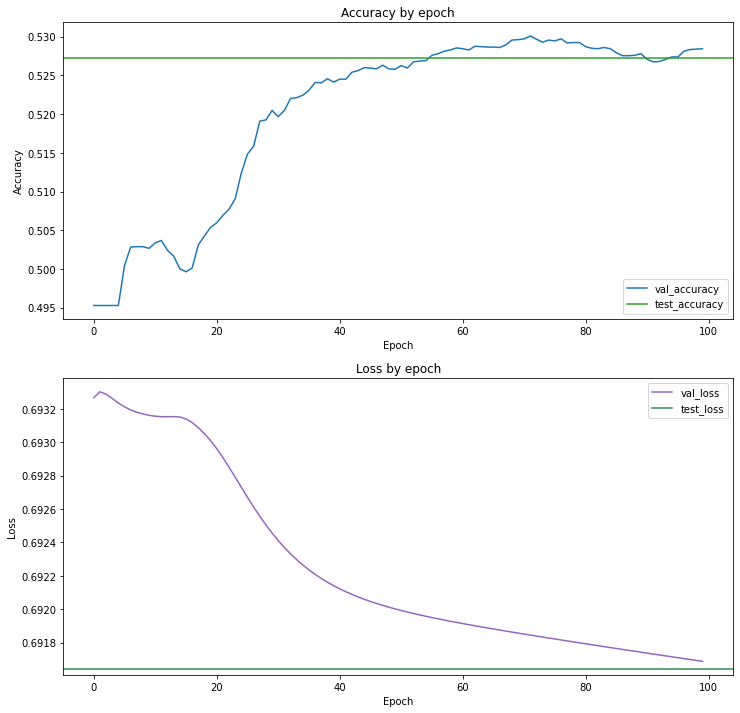

In [18]:
# plot
figs, axes = plt.subplots(nrows=2, figsize=(12, 12))

# accuracy
# axes[0].plot(df_train['epoch'], df_train['train_accuracy'], color='tab:red', label='train_accuracy')
axes[0].plot(df_val['epoch'], df_val['val_accuracy'], color='tab:blue', label='val_accuracy')
axes[0].axhline(test_acc, color='tab:green', label='test_accuracy')

# loss
# axes[1].plot(df_train['epoch'], df_train['train_loss'], color='tab:orange', label='train_loss')
axes[1].plot(df_val['epoch'], df_val['val_loss'], color='tab:purple', label='val_loss')
axes[1].axhline(test_loss, color='seagreen', label='test_loss')

# label, title, make pretty
titles = ['Accuracy by epoch', 'Loss by epoch']
dependent = ['Accuracy', 'Loss']
for i in range(2):
    axes[i].legend()
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(dependent[i])
plt.show()